In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import os

## GPR on different data quality

In [2]:
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)

def f_mse(y, y_gt):
    return np.mean((y-y_gt)**2)/np.mean((y_gt)**2)

def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    return I_des

def f_log_likelihood(y, y_err, x, x_err, z_list = np.linspace(0, 0, 1), importance = None, index = None):
    """
    likelihood of y in the distribution of x
    """
    ## average over the ovservation uncertainty   
    log_likelihood = 0   
    sum_weight = 0  
    
    if importance is None:
        importance = np.ones(len(y))
    if index is None:
        index = np.arange(len(y))
    
    for z in z_list:
        weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
        y_z = y + y_err*z
        log_likelihood_z = -0.5 * np.sum((((y_z - x)**2 / x_err**2 + np.log(2 * np.pi * x_err**2))*importance)[index])
        log_likelihood += log_likelihood_z*weight_z
        sum_weight += weight_z
    log_likelihood = log_likelihood/sum_weight
    return log_likelihood



## 1. EQSANS-SDS

In [3]:
# Define the folder path
folder_path = './data/EQSANS/SDS/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[6]) for filename in filenames if filename.endswith('.dat')])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'SDS_5mgmL_20C_4m_fbt_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt('./data/EQSANS/SDS/'+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
filename_list = [f'SDS_5mgmL_20C_4m_fbt_0_{i:0.0f}_Iqxqy.dat' for i in time_list]
label_list = [f'time_0_{i:0.0f}' for i in time_list]
data_2D_list = []

for i_file, filename in enumerate(filename_list):
    data = np.loadtxt('./data/EQSANS/SDS/'+filename, skiprows=4)
    data_2D_list.append(data)

0 1.0
1 2.0
2 3.0
3 4.0
4 5.0
5 6.0
6 7.0
7 8.0
8 9.0
9 10.0
10 15.0
11 20.0
12 25.0
13 30.0
14 60.0
15 90.0
16 120.0
17 240.0
18 360.0
19 480.0
20 600.0
21 720.0


In [4]:
n_trial = 1
filter_size = 0.5
I_bg = 0.001
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):
    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.4)|(q_data < 0.015)  
        index_outlier = (q_data < 0.4)&(q_data > 0.015)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.225
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        importance = np.where((q_data > 0.014)&(q_data < 0.4), 1, 0)
        # importance = None
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)
    
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

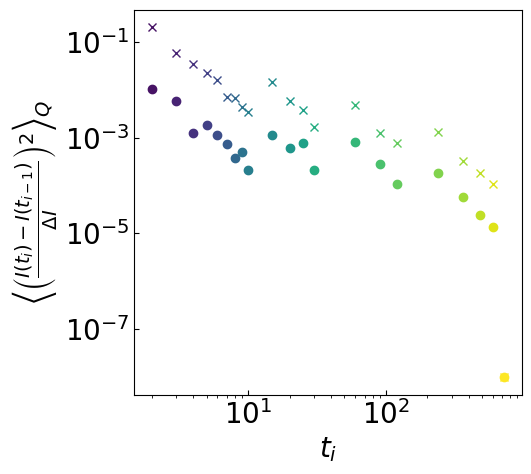

In [5]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_SDS.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

## 2. EQSANS-23463

### a1 4m12a

In [6]:
# Define the folder path
folder_path = './data/EQSANS/output_23463/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '4m12a' in filename and 'a1' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'a1_4m12a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0


In [7]:
n_trial = 1
filter_size = 0.11
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.001)  
        index_outlier = (q_data < 0.080)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.2
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        sigma_best = 1
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

<Figure size 640x480 with 0 Axes>

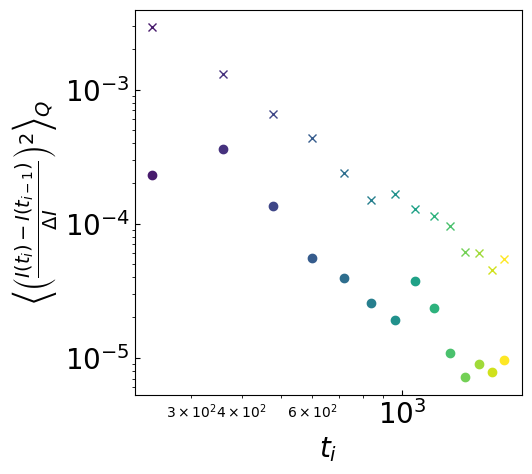

In [8]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_23463-4m12a-a1.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

### t3 4m12a

In [9]:
# Define the folder path
folder_path = './data/EQSANS/output_23463/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '4m12a' in filename and 't3' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f't3_4m12a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0


In [10]:
n_trial = 1
filter_size = 0.11
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.09)|(q_data < 0.005)  
        index_outlier = (q_data < 0.09)&(q_data > 0.005)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.2
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1
        
        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.09)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

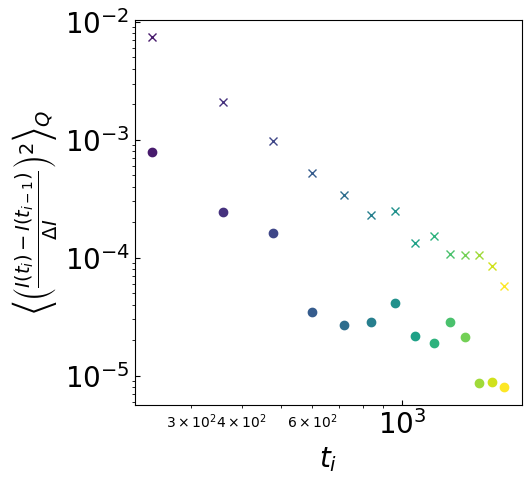

In [11]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_23463-4m12a-t3.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

## EQSANS-22386

### CVWLM2 9m15a

In [12]:
# Define the folder path
folder_path = './data/EQSANS/output_22386/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'CVWLM1' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'CVWLM2_20C_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0


In [13]:
n_trial = 1
filter_size = 0.2
I_bg = 1
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.03)|(q_data < 0.001)  
        index_outlier = (q_data < 0.03)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(5):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.25
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
        
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.03)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

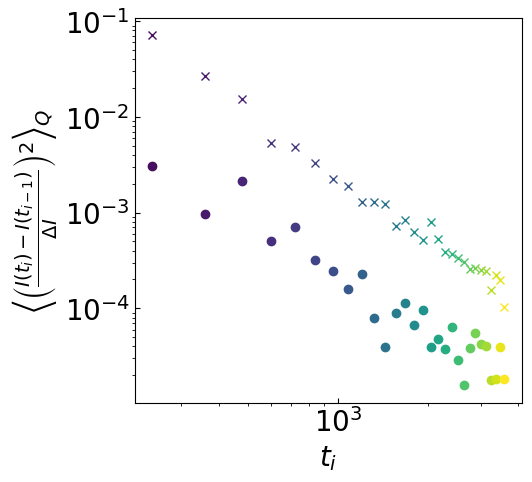

In [14]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22386-9m15a-CVWLM2.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

### CVWLM7 9m15a

In [15]:
# Define the folder path
folder_path = './data/EQSANS/output_22386/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'CVWLM7' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'CVWLM7_20C_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0


In [16]:
n_trial = 1
filter_size = 0.2
I_bg = 1
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.03)|(q_data < 0.001)  
        index_outlier = (q_data < 0.03)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(5):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.25
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
        
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.03)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

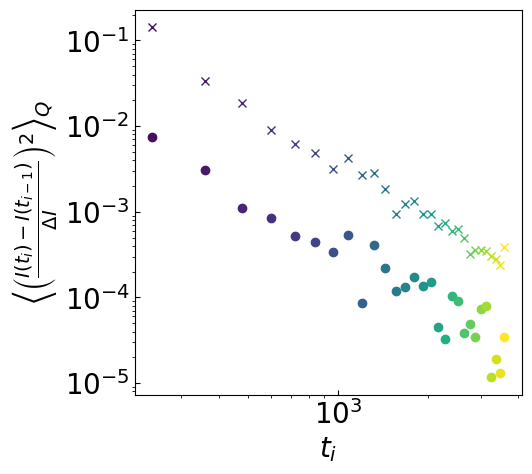

In [17]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22386-9m15a-CVWLM7.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

## EQSANS-22170

### S5A 8m8a

In [18]:
# Define the folder path
folder_path = './data/EQSANS/output_22170/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '8m8a' in filename and 'S5A' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'S5A_20C_8m8a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0


In [19]:
n_trial = 1
filter_size = 0.225
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.003)  
        index_outlier = (q_data < 0.080)&(q_data > 0.003)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.225
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.002) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

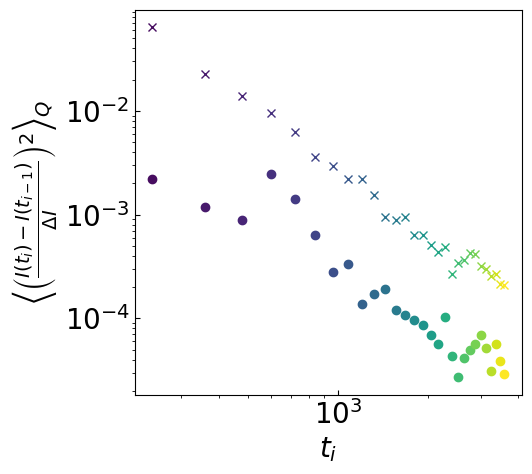

In [20]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22170-8m8a-S5A.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

### S3A 8m8a

In [21]:
# Define the folder path
folder_path = './data/EQSANS/output_22170/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '8m8a' in filename and 'S3A' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'S3A_20C_8m8a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0


In [22]:
n_trial = 1
filter_size = 0.225
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.003)  
        index_outlier = (q_data < 0.080)&(q_data > 0.003)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.225
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.002) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

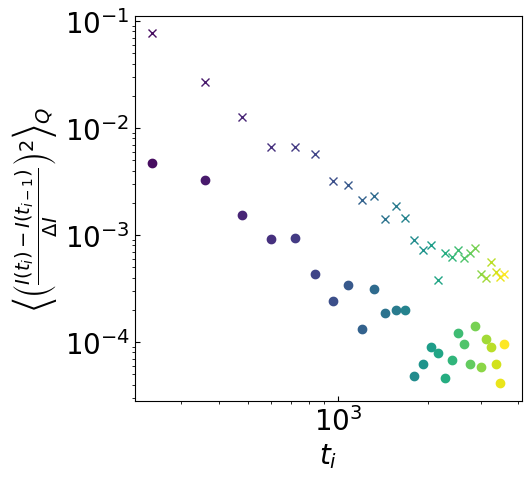

In [23]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22170-8m8a-S3A.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

### S1A 8m8a

In [24]:
# Define the folder path
folder_path = './data/EQSANS/output_22170/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '8m8a' in filename and 'S1A' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'S1A_20C_8m8a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
30 3720.0
31 3840.0
32 3960.0
33 4080.0
34 4200.0
35 4320.0
36 4440.0
37 4560.0
38 4680.0
39 4800.0
40 4920.0


In [25]:
n_trial = 1
filter_size = 0.225
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.003)  
        index_outlier = (q_data < 0.080)&(q_data > 0.003)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.225
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.002) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

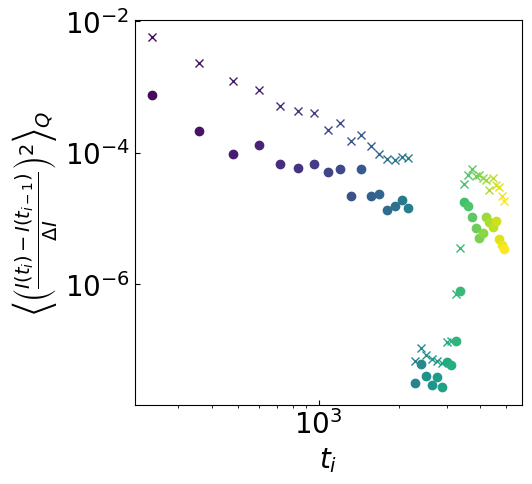

In [26]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22170-8m8a-S1A.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

## EQSANS-22193

### ws1 9m15a

In [27]:
# Define the folder path
folder_path = './data/EQSANS/output_22193/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'ws1' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'ws1_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0


In [28]:
n_trial = 1
filter_size = 0.11
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.001)  
        index_outlier = (q_data < 0.080)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.2
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

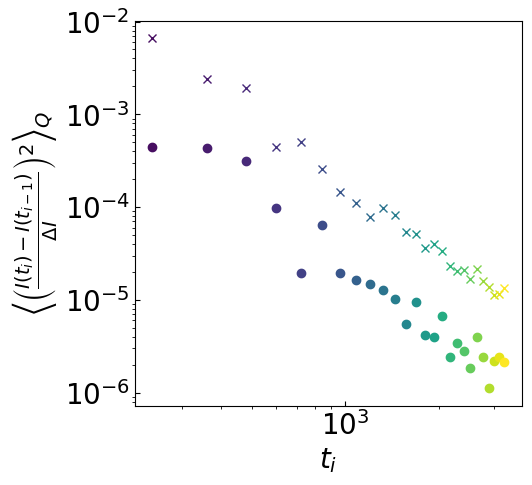

In [29]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws1.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

### ws2 9m15a

In [30]:
# Define the folder path
folder_path = './data/EQSANS/output_22193/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'ws2' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'ws2_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0


In [31]:
n_trial = 1
filter_size = 0.11
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.001)  
        index_outlier = (q_data < 0.080)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.2
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

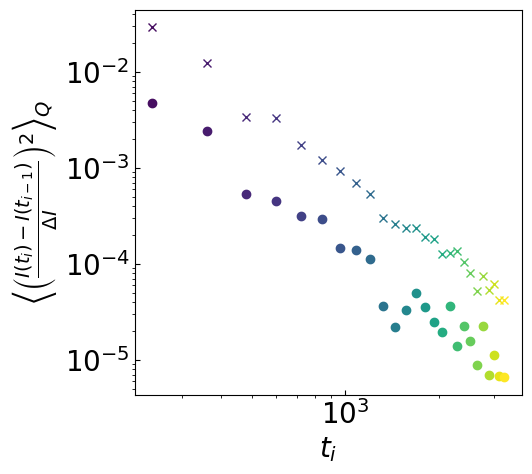

In [32]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws2.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

### ws3 9m15a

In [33]:
# Define the folder path
folder_path = './data/EQSANS/output_22193/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'ws3' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'ws3_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0


In [34]:
n_trial = 1
filter_size = 0.11
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.001)  
        index_outlier = (q_data < 0.080)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.2
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

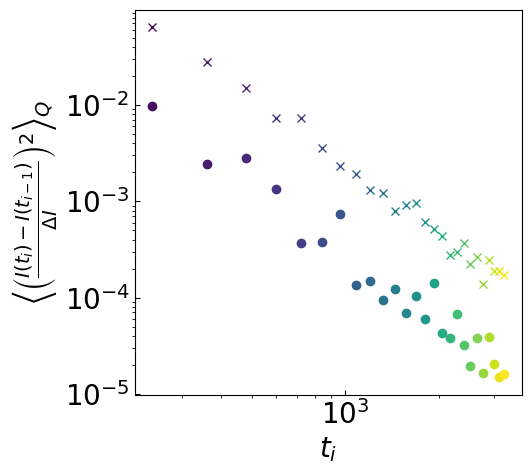

In [35]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws3.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

### ws4 9m15a

In [36]:
# Define the folder path
folder_path = './data/EQSANS/output_22193/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'ws4' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'ws4_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0


In [37]:
n_trial = 1
filter_size = 0.11
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.001)  
        index_outlier = (q_data < 0.080)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.2
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

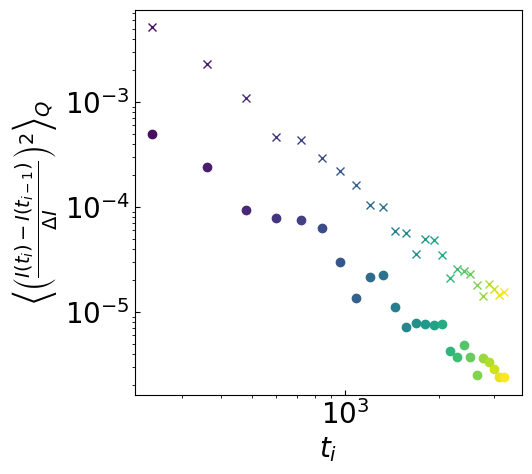

In [38]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws4.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

### ws5 9m15a

In [39]:
# Define the folder path
folder_path = './data/EQSANS/output_22193/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'ws5' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'ws5_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0


In [40]:
n_trial = 1
filter_size = 0.11
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.001)  
        index_outlier = (q_data < 0.080)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.2
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

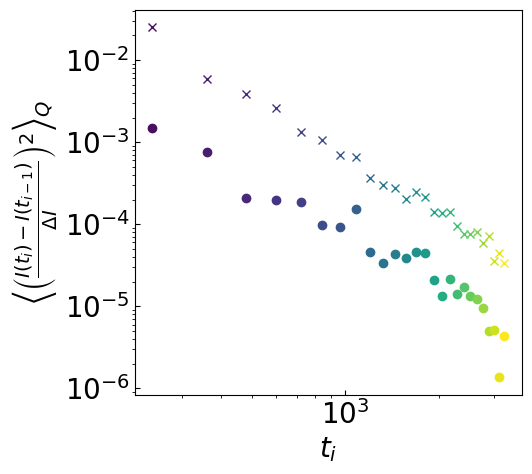

In [41]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws5.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

### ws6 9m15a

In [42]:
# Define the folder path
folder_path = './data/EQSANS/output_22193/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'ws6' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'ws6_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0


In [43]:
n_trial = 1
filter_size = 0.11
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.001)  
        index_outlier = (q_data < 0.080)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.2
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

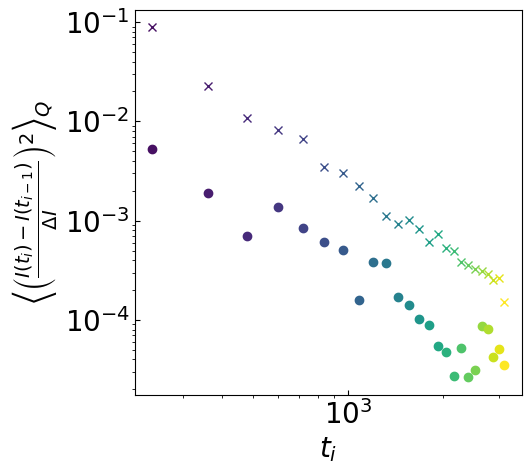

In [44]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws6.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')

## EQSANS-25953

### 9_1mm_25C 9m15a

In [45]:
# Define the folder path
folder_path = './data/EQSANS/output_25953/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[6]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and '9_1mm_25C' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'9_1mm_25C_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
30 3720.0
31 3840.0
32 3960.0
33 4080.0
34 4200.0
35 4320.0
36 4440.0
37 4560.0
38 4680.0
39 4800.0
40 4920.0
41 5040.0
42 5160.0
43 5280.0
44 5400.0
45 5520.0
46 5640.0
47 5760.0


In [46]:
n_trial = 1
filter_size = 0.1
I_bg = 0.1
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.035)|(q_data < 0.0012)  
        index_outlier = (q_data < 0.035)&(q_data > 0.0012)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(2):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.12
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
        
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # # ax.legend(frameon=False, fontsize=13, ncol=2)
        # plt.tight_layout()
        
        sigma_best = 1

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.035)|(q_data < 0.0015) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

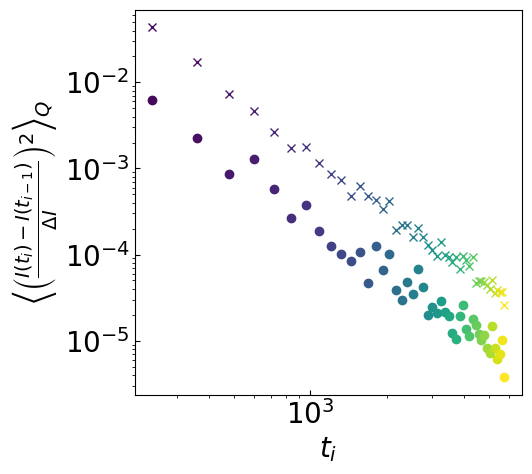

In [ ]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_MeanRelativeError = []
list_MeanRelativeError_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    data_prev = data_list[i_t-1]
    I_exp_prev = data_prev[:, 1]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) 
    
    MeanRelativeChange = np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2)
    MeanRelativeChange_exp = np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2)
    list_MeanRelativeError.append(MeanRelativeChange)
    list_MeanRelativeError_exp.append(MeanRelativeChange_exp)
    
    ax2.plot(time, MeanRelativeChange, 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, MeanRelativeChange_exp, 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left(\frac{I(t_i) - I(t_{i-1})}{\Delta I}\right)^2\right\rangle_Q$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
array_MeanRelativeChange = np.array(list_MeanRelativeError)
array_MeanRelativeChange_exp = np.array(list_MeanRelativeError_exp)
array_time = np.array(time_list[1:])
    
filename = './data_MeanRelativeChange/MeanRelativeChange_25953-9m15a-9.dat'
np.savetxt(filename, np.c_[array_time, array_MeanRelativeChange, array_MeanRelativeChange_exp], header='time/counts MeanRelativeChange MeanRelativeChange_exp', fmt='%0.8f')